#IMPORTAR BIBLIOTECAS Y DB

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import glob
import gc
import pyarrow.parquet as pq
import pyarrow as pa


In [2]:
#montar drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Unión DB 2020 - 2025

In [4]:
#UNION DE DATASET DE 2020 A 2025
BASE_PATH = '/content/drive/MyDrive/Curso_Oracle/HACKATON/DataRaw'
YEARS = [2020, 2021, 2022, 2023, 2024, 2025]

# Columnas maestras
COLUMNAS_MAESTRA = [
    'YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
    'OP_UNIQUE_CARRIER', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST', 'DEST_CITY_NAME',
    'CRS_DEP_TIME', 'DEP_DELAY', 'DEP_DEL15',
    'CANCELLED', 'DIVERTED', 'DISTANCE'
]

In [5]:
#crear parquets limpios de todos los años

for year in YEARS:
    print(f"⌛ Procesando año {year}...")
    year_path = os.path.join(BASE_PATH, str(year))
    df_list = []

    # --- LÓGICA DE LECTURA ---
    if year == 2024:
        # Caso Kaggle: Archivo único
        kaggle_file = os.path.join(year_path, 'flight_data_2024.csv')
        if os.path.exists(kaggle_file):
            try:
                # Usamos encoding latin1 para evitar el UnicodeDecodeError
                df_temp = pd.read_csv(kaggle_file, encoding='latin1', low_memory=False)
                df_list.append(df_temp)
            except Exception as e:
                print(f"❌ Error leyendo Kaggle 2024: {e}")
    else:
        # Caso BTS: Carpetas mensuales
        pattern = os.path.join(year_path, '*', 'T_ONTIME_REPORTING.csv')
        monthly_files = glob.glob(pattern)
        for f in monthly_files:
            try:
                df_m = pd.read_csv(f, low_memory=False)
                df_list.append(df_m)
            except Exception as e:
                print(f"⚠️ Error en {f}: {e}")

    # --- PROCESAMIENTO Y LIMPIEZA ---
    if df_list:
        df_year = pd.concat(df_list, ignore_index=True)

        # 1. Estandarizar nombres a MAYÚSCULAS inmediatamente
        df_year.columns = df_year.columns.str.upper()

        # 2. CASO ESPECIAL 2024: Crear DEP_DEL15 si no existe
        if 'DEP_DEL15' not in df_year.columns and 'DEP_DELAY' in df_year.columns:
            df_year['DEP_DEL15'] = (df_year['DEP_DELAY'] >= 15).astype(float)

        # 3. FILTRADO OPERATIVO: Eliminar vuelos cancelados o desviados
        # Esto reduce el peso del dataset significativamente
        if 'CANCELLED' in df_year.columns:
            df_year = df_year[df_year['CANCELLED'] == 0].copy()
        if 'DIVERTED' in df_year.columns:
            df_year = df_year[df_year['DIVERTED'] == 0].copy()

        # 4. ELIMINAR NULOS EN EL TARGET
        # Sin estos datos, el modelo no puede aprender patrones de retraso
        df_year = df_year.dropna(subset=['DEP_DELAY', 'DEP_DEL15'])

        # 5. ASEGURAR COLUMNAS Y BLINDAR TIPOS DE DATOS
        # Forzamos float64 para que la unión final no falle por Schema Mismatch
        for col in COLUMNAS_MAESTRA:
            if col not in df_year.columns:
                df_year[col] = pd.NA

        cols_num = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME',
                    'DISTANCE', 'DEP_DELAY', 'DEP_DEL15']

        for c in cols_num:
            df_year[c] = pd.to_numeric(df_year[c], errors='coerce').astype('float64')

        # 6. GUARDADO INDIVIDUAL
        # Eliminamos CANCELLED y DIVERTED antes de guardar pues ya son todo 0
        df_year = df_year[COLUMNAS_MAESTRA].drop(columns=['CANCELLED', 'DIVERTED'], errors='ignore')

        output_file = f'{BASE_PATH}/vuelos_{year}_CLEAN.parquet'
        df_year.to_parquet(output_file, index=False)
        print(f"✅ Archivo READY creado: {output_file} ({len(df_year):,} filas)")

        # Limpieza de RAM
        del df_year, df_list
        gc.collect()


⌛ Procesando año 2020...
✅ Archivo READY creado: /content/drive/MyDrive/Curso_Oracle/HACKATON/DataRaw/vuelos_2020_CLEAN.parquet (4,399,576 filas)
⌛ Procesando año 2021...
✅ Archivo READY creado: /content/drive/MyDrive/Curso_Oracle/HACKATON/DataRaw/vuelos_2021_CLEAN.parquet (5,878,220 filas)
⌛ Procesando año 2022...
✅ Archivo READY creado: /content/drive/MyDrive/Curso_Oracle/HACKATON/DataRaw/vuelos_2022_CLEAN.parquet (6,532,013 filas)
⌛ Procesando año 2023...
✅ Archivo READY creado: /content/drive/MyDrive/Curso_Oracle/HACKATON/DataRaw/vuelos_2023_CLEAN.parquet (6,743,404 filas)
⌛ Procesando año 2024...
✅ Archivo READY creado: /content/drive/MyDrive/Curso_Oracle/HACKATON/DataRaw/vuelos_2024_CLEAN.parquet (6,965,267 filas)
⌛ Procesando año 2025...
✅ Archivo READY creado: /content/drive/MyDrive/Curso_Oracle/HACKATON/DataRaw/vuelos_2025_CLEAN.parquet (5,150,695 filas)


In [6]:
#Validación
archivos_listos = glob.glob(f'{BASE_PATH}/vuelos_20*.parquet')
print(f"Tienes {len(archivos_listos)} archivos listos:")
for f in sorted(archivos_listos):
    size_mb = os.path.getsize(f) / (1024 * 1024)
    print(f"📄 {os.path.basename(f)} - {size_mb:.2f} MB")

Tienes 6 archivos listos:
📄 vuelos_2020_CLEAN.parquet - 36.34 MB
📄 vuelos_2021_CLEAN.parquet - 49.26 MB
📄 vuelos_2022_CLEAN.parquet - 54.91 MB
📄 vuelos_2023_CLEAN.parquet - 56.69 MB
📄 vuelos_2024_CLEAN.parquet - 58.54 MB
📄 vuelos_2025_CLEAN.parquet - 43.31 MB


In [7]:
#union de todos LoS AÑOS
# Buscar archivos generados
archivos_ready = sorted(glob.glob(f'{BASE_PATH}/vuelos_*_CLEAN.parquet'))
MASTER_FILE = f'{BASE_PATH}/vuelos_MASTER_FINAL_2020_2025.parquet'

print(f"📚 Uniendo {len(archivos_ready)} archivos optimizados...")

writer = None
for f in archivos_ready:
    print(f"Añadiendo al maestro: {os.path.basename(f)}...")
    table = pa.Table.from_pandas(pd.read_parquet(f), preserve_index=False)

    if writer is None:
        writer = pq.ParquetWriter(MASTER_FILE, table.schema)

    writer.write_table(table)
    del table
    gc.collect()

if writer:
    writer.close()

print(f"✨ ¡Dataset Maestro consolidado con éxito! Ubicación: {MASTER_FILE}")

📚 Uniendo 6 archivos optimizados...
Añadiendo al maestro: vuelos_2020_CLEAN.parquet...
Añadiendo al maestro: vuelos_2021_CLEAN.parquet...
Añadiendo al maestro: vuelos_2022_CLEAN.parquet...
Añadiendo al maestro: vuelos_2023_CLEAN.parquet...
Añadiendo al maestro: vuelos_2024_CLEAN.parquet...
Añadiendo al maestro: vuelos_2025_CLEAN.parquet...
✨ ¡Dataset Maestro consolidado con éxito! Ubicación: /content/drive/MyDrive/Curso_Oracle/HACKATON/DataRaw/vuelos_MASTER_FINAL_2020_2025.parquet


##IMPORTAR BASES

In [2]:
# DF vuelos 2020 a 2025
df_flights = pd.read_parquet('/content/drive/MyDrive/Curso_Oracle/HACKATON/DataRaw/vuelos_MASTER_FINAL_2020_2025.parquet')

print(df_flights.head())

     YEAR  MONTH  DAY_OF_MONTH  DAY_OF_WEEK               FL_DATE  \
0  2020.0    4.0           1.0          3.0  4/1/2020 12:00:00 AM   
1  2020.0    4.0           1.0          3.0  4/1/2020 12:00:00 AM   
2  2020.0    4.0           1.0          3.0  4/1/2020 12:00:00 AM   
3  2020.0    4.0           1.0          3.0  4/1/2020 12:00:00 AM   
4  2020.0    4.0           1.0          3.0  4/1/2020 12:00:00 AM   

  OP_UNIQUE_CARRIER ORIGIN ORIGIN_CITY_NAME DEST  DEST_CITY_NAME  \
0                9E    ATL      Atlanta, GA  CSG    Columbus, GA   
1                9E    DTW      Detroit, MI  EVV  Evansville, IN   
2                9E    ATL      Atlanta, GA  RST   Rochester, MN   
3                9E    RST    Rochester, MN  ATL     Atlanta, GA   
4                9E    DTW      Detroit, MI  TYS   Knoxville, TN   

   CRS_DEP_TIME  DEP_DELAY  DEP_DEL15  DISTANCE  
0        2002.0       -7.0        0.0      83.0  
1        2026.0        8.0        0.0     363.0  
2        1352.0       -4.0

In [3]:
#MAESTRO DE AEROPUERTOS CON COORDENADAS DE BTS
df_master = pd.read_csv('/content/T_MASTER_CORD.csv')
df_master.head()

,AIRPORT_SEQ_ID,AIRPORT_ID,AIRPORT,DISPLAY_AIRPORT_NAME,DISPLAY_AIRPORT_CITY_NAME_FULL,AIRPORT_WAC_SEQ_ID2,AIRPORT_WAC,AIRPORT_COUNTRY_NAME,AIRPORT_COUNTRY_CODE_ISO,AIRPORT_STATE_NAME,...,LON_DEGREES,LON_HEMISPHERE,LON_MINUTES,LON_SECONDS,LONGITUDE,UTC_LOCAL_TIME_VARIATION,AIRPORT_START_DATE,AIRPORT_THRU_DATE,AIRPORT_IS_CLOSED,AIRPORT_IS_LATEST
0,1000101,10001,01A,Afognak Lake Airport,"Afognak Lake, AK",101,1,United States,US,Alaska,...,152.0,W,54.0,24.0,-152.906667,NaN,7/1/2007 12:00:00 AM,NaN,0,1
1,1000301,10003,03A,Bear Creek Mining Strip,"Granite Mountain, AK",101,1,United States,US,Alaska,...,161.0,W,4.0,18.0,-161.071667,NaN,7/1/2007 12:00:00 AM,NaN,0,1
2,1000401,10004,04A,Lik Mining Camp,"Lik, AK",101,1,United States,US,Alaska,...,163.0,W,10.0,0.0,-163.166667,NaN,7/1/2007 12:00:00 AM,NaN,0,1
3,1000501,10005,05A,Little Squaw Airport,"Little Squaw, AK",101,1,United States,US,Alaska,...,148.0,W,11.0,2.0,-148.183889,NaN,8/1/2007 12:00:00 AM,NaN,0,1
4,1000601,10006,06A,Kizhuyak Bay,"Kizhuyak, AK",101,1,United States,US,Alaska,...,152.0,W,52.0,58.0,-152.882778,NaN,10/1/2007 12:00:00 AM,NaN,0,1


In [4]:
#ISD histórico de NOAA que contiene info de estaciones con coordenadas
df_isd = pd.read_csv('/content/isd-history.csv')
df_isd.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
0,007018,99999,WXPOD 7018,NaN,NaN,NaN,0.00,0.000,7018.0,20110309,20130730
1,007026,99999,WXPOD 7026,AF,NaN,NaN,0.00,0.000,7026.0,20120713,20170822
2,007070,99999,WXPOD 7070,AF,NaN,NaN,0.00,0.000,7070.0,20140923,20150926
3,008260,99999,WXPOD8270,NaN,NaN,NaN,0.00,0.000,0.0,20050101,20120731
4,008268,99999,WXPOD8278,AF,NaN,NaN,32.95,65.567,1156.7,20100519,20120323


#ANALIS EXPLORATORIO + LIMPIEZA

###Diccionario de Variables Seleccionadas (BTS y Kaggle)

| Columna | Tipo | Ejemplo | Descripción y Utilidad |
| :--- | :--- | :--- | :--- |
| **YEAR** | int64 | 2024 | Control: Filtro temporal para separar años de entrenamiento y prueba. |
| **MONTH** | int64 | 1 | Feature: Captura la estacionalidad climática (invierno vs verano). |
| **DAY_OF_MONTH** | int64 | 15 | Feature: Patrones de tráfico por quincena o días específicos del mes. |
| **DAY_OF_WEEK** | int64 | 5 | Feature: Diferencia entre días laborales y fines de semana. |
| **FL_DATE** | datetime | 2024-01-15 | Key: Esencial para hacer el merge con los datos del NOAA. |
| **OP_UNIQUE_CARRIER**| str | AA | Feature: Identifica la aerolínea y su puntualidad histórica. |
| **ORIGIN** | str | JFK | Feature: Puerto de salida; identifica congestión en origen. |
| **DEST** | str | LAX | Feature: Puerto de llegada; identifica saturación en destino. |
| **CRS_DEP_TIME** | int64 | 1345 | Crucial: Hora programada. Variable predictora principal. |
| **CRS_ARR_TIME** | int64 | 1600 | Feature: Hora de llegada programada. |
| **DISTANCE** | float64 | 2475 | Feature: Distancia del vuelo; permite calcular recuperación de tiempo. |
| **DEP_DELAY** | float64 | 15.0 | Target (Regresión): Minutos de retraso (valores negativos son 0). |
| **DEP_DEL15** | float64 | 1.0 | Target (Clasificación): 1 si hay retraso >15 min, 0 si no. |
| **CANCELLED** | int64 | 0 | Filtro: Se usa para limpiar el dataset (solo mantener registros con 0). |
| **DIVERTED** | int64 | 0 | Filtro: Se usa para limpiar el dataset (solo mantener registros con 0). |
| **DEP_HOUR** | int8 | 13 | Feature: Extrae la hora (HH) de la salida programada (0-23) para captar patrones horarios de congestión. |
| **sched_minute_of_day** | int16 | 825 | Feature: Minutos totales transcurridos desde el inicio del día (0-1440). |
| **distance_bin** | category | (834.0, 1042.0) | Feature: Agrupación de la distancia en 10 deciles de igual frecuencia. Ayuda al modelo a captar comportamientos no lineales según la longitud del vuelo.. |

In [5]:
# Ver los años presentes y cuántos vuelos hay en cada uno
print(df_flights['YEAR'].value_counts().sort_index())


YEAR
2020.0    4399576
2021.0    5878220
2022.0    6532013
2023.0    6743404
2024.0    6965267
2025.0    5150695
Name: count, dtype: int64


In [6]:
df_flights.columns

Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'OP_UNIQUE_CARRIER', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST',
       'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_DELAY', 'DEP_DEL15', 'DISTANCE'],
      dtype='object')

In [7]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35669175 entries, 0 to 35669174
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   YEAR               float64
 1   MONTH              float64
 2   DAY_OF_MONTH       float64
 3   DAY_OF_WEEK        float64
 4   FL_DATE            object 
 5   OP_UNIQUE_CARRIER  object 
 6   ORIGIN             object 
 7   ORIGIN_CITY_NAME   object 
 8   DEST               object 
 9   DEST_CITY_NAME     object 
 10  CRS_DEP_TIME       float64
 11  DEP_DELAY          float64
 12  DEP_DEL15          float64
 13  DISTANCE           float64
dtypes: float64(8), object(6)
memory usage: 3.7+ GB


In [8]:
##TRASNFORMACIÓN DE DATOS:
# Convertir fechas a formato datetime real
df_flights['FL_DATE'] = pd.to_datetime(df_flights['FL_DATE'], errors='coerce')

# Convertir columnas numéricas de float64 a tipos más ligeros
# Usamos 'Int16' o 'int16' para años y meses porque ocupan solo 2 bytes
# YEAR como entero (2020, 2024, etc)
df_flights['YEAR'] = df_flights['YEAR'].astype('int16')
df_flights['MONTH'] = df_flights['MONTH'].astype('int8') # 1 a 12 cabe en int8
df_flights['DAY_OF_MONTH'] = df_flights['DAY_OF_MONTH'].astype('int8')
df_flights['DAY_OF_WEEK'] = df_flights['DAY_OF_WEEK'].astype('int8')

#Optimizar el Target (DEP_DEL15 es binario 0 o 1)
df_flights['DEP_DEL15'] = df_flights['DEP_DEL15'].astype('int8')

#Optimizar Horas y Distancia (pueden ser int16 ya que no superan 32,767)
df_flights['CRS_DEP_TIME'] = df_flights['CRS_DEP_TIME'].astype('int16')
df_flights['DISTANCE'] = df_flights['DISTANCE'].astype('int16')

#Optimización de Columnas Categóricas
categorical_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME']
for col in categorical_cols:
    df_flights[col] = df_flights[col].astype('category')

#DEP_DELAY se queda como float porque puede tener nulos o decimales específicos
df_flights['DEP_DELAY'] = df_flights['DEP_DELAY'].astype('float32')


# Ver reporte de ahorro
print(f"📊 Nueva memoria utilizada: {df_flights.memory_usage().sum() / 1024**2:.2f} MB")
df_flights.info()

/tmp/ipython-input-502779696.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_flights['FL_DATE'] = pd.to_datetime(df_flights['FL_DATE'], errors='coerce')


📊 Nueva memoria utilizada: 1054.56 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35669175 entries, 0 to 35669174
Data columns (total 14 columns):
 #   Column             Dtype         
---  ------             -----         
 0   YEAR               int16         
 1   MONTH              int8          
 2   DAY_OF_MONTH       int8          
 3   DAY_OF_WEEK        int8          
 4   FL_DATE            datetime64[ns]
 5   OP_UNIQUE_CARRIER  category      
 6   ORIGIN             category      
 7   ORIGIN_CITY_NAME   category      
 8   DEST               category      
 9   DEST_CITY_NAME     category      
 10  CRS_DEP_TIME       int16         
 11  DEP_DELAY          float32       
 12  DEP_DEL15          int8          
 13  DISTANCE           int16         
dtypes: category(5), datetime64[ns](1), float32(1), int16(3), int8(4)
memory usage: 1.0 GB


In [9]:
# Conteo de nulos absoluto y porcentual
nulos_reporte = pd.DataFrame({
    'Nulos': df_flights.isnull().sum(),
    '% Nulos': (df_flights.isnull().sum() / len(df_flights)) * 100
})
print("📊 Reporte de Nulos por Columna:")
print(nulos_reporte.sort_values(by='Nulos', ascending=False))

📊 Reporte de Nulos por Columna:
                   Nulos  % Nulos
YEAR                   0      0.0
MONTH                  0      0.0
DAY_OF_MONTH           0      0.0
DAY_OF_WEEK            0      0.0
FL_DATE                0      0.0
OP_UNIQUE_CARRIER      0      0.0
ORIGIN                 0      0.0
ORIGIN_CITY_NAME       0      0.0
DEST                   0      0.0
DEST_CITY_NAME         0      0.0
CRS_DEP_TIME           0      0.0
DEP_DELAY              0      0.0
DEP_DEL15              0      0.0
DISTANCE               0      0.0


In [10]:
# CREAR COLUMNAS ADICIONALES DE INFO NECESARIA PARA ANÁLISIS
# 1. Extraer la hora (HH) - Usamos int8 (0-23)
df_flights['DEP_HOUR'] = (df_flights['CRS_DEP_TIME'] // 100).astype('int8')

# 2. Crear 'sched_minute_of_day' - Usamos int16 (0-1440)
# El minuto del día es vital para captar picos de tráfico aéreo.
sched_hour = df_flights['CRS_DEP_TIME'] // 100
sched_min = df_flights['CRS_DEP_TIME'] % 100
df_flights['sched_minute_of_day'] = ((sched_hour * 60) + sched_min).astype('int16')

# 3. Binning de Distancia
# pd.qcut crea categorías, las cuales son muy eficientes en memoria.
df_flights['distance_bin'] = pd.qcut(df_flights['DISTANCE'], q=10, duplicates='drop')

print(f"✅ Features creadas. Dimensiones: {df_flights.shape}")
print(f"📊 Memoria actual: {df_flights.memory_usage().sum() / 1024**2:.2f} MB")

df_flights.head()

✅ Features creadas. Dimensiones: (35669175, 17)
📊 Memoria actual: 1190.63 MB


,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_DELAY,DEP_DEL15,DISTANCE,DEP_HOUR,sched_minute_of_day,distance_bin
0,2020,4,1,3,2020-04-01,9E,ATL,"Atlanta, GA",CSG,"Columbus, GA",2002,-7.0,0,83,20,1202,"(10.999, 228.0]"
1,2020,4,1,3,2020-04-01,9E,DTW,"Detroit, MI",EVV,"Evansville, IN",2026,8.0,0,363,20,1226,"(337.0, 438.0]"
2,2020,4,1,3,2020-04-01,9E,ATL,"Atlanta, GA",RST,"Rochester, MN",1352,-4.0,0,831,13,832,"(674.0, 837.0]"
3,2020,4,1,3,2020-04-01,9E,RST,"Rochester, MN",ATL,"Atlanta, GA",1559,-17.0,0,831,15,959,"(674.0, 837.0]"
4,2020,4,1,3,2020-04-01,9E,DTW,"Detroit, MI",TYS,"Knoxville, TN",2020,-7.0,0,443,20,1220,"(438.0, 562.0]"


In [11]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35669175 entries, 0 to 35669174
Data columns (total 17 columns):
 #   Column               Dtype         
---  ------               -----         
 0   YEAR                 int16         
 1   MONTH                int8          
 2   DAY_OF_MONTH         int8          
 3   DAY_OF_WEEK          int8          
 4   FL_DATE              datetime64[ns]
 5   OP_UNIQUE_CARRIER    category      
 6   ORIGIN               category      
 7   ORIGIN_CITY_NAME     category      
 8   DEST                 category      
 9   DEST_CITY_NAME       category      
 10  CRS_DEP_TIME         int16         
 11  DEP_DELAY            float32       
 12  DEP_DEL15            int8          
 13  DISTANCE             int16         
 14  DEP_HOUR             int8          
 15  sched_minute_of_day  int16         
 16  distance_bin         category      
dtypes: category(6), datetime64[ns](1), float32(1), int16(4), int8(5)
memory usage: 1.2 GB


##Master

| Columna | Tipo | Ejemplo | Descripción y Utilidad |
| :--- | :--- | :--- | :--- |
| **AIRPORT** | object | JFK | Key: Código IATA del aeropuerto. Se une con ORIGIN/DEST. |
| **DISPLAY_AIRPORT_NAME** | object | John F. Kennedy International | Info: Nombre completo para visualizaciones y reportes. |
| **LATITUDE** | float64 | 40.639 | Feature: Ubicación para calcular distancias climáticas. |
| **LONGITUDE** | float64 | -73.778 | Feature: Ubicación para análisis geoespacial. |


In [12]:
df_master.columns

Index(['AIRPORT_SEQ_ID', 'AIRPORT_ID', 'AIRPORT', 'DISPLAY_AIRPORT_NAME',
       'DISPLAY_AIRPORT_CITY_NAME_FULL', 'AIRPORT_WAC_SEQ_ID2', 'AIRPORT_WAC',
       'AIRPORT_COUNTRY_NAME', 'AIRPORT_COUNTRY_CODE_ISO',
       'AIRPORT_STATE_NAME', 'AIRPORT_STATE_CODE', 'AIRPORT_STATE_FIPS',
       'CITY_MARKET_SEQ_ID', 'CITY_MARKET_ID', 'DISPLAY_CITY_MARKET_NAME_FULL',
       'CITY_MARKET_WAC_SEQ_ID2', 'CITY_MARKET_WAC', 'LAT_DEGREES',
       'LAT_HEMISPHERE', 'LAT_MINUTES', 'LAT_SECONDS', 'LATITUDE',
       'LON_DEGREES', 'LON_HEMISPHERE', 'LON_MINUTES', 'LON_SECONDS',
       'LONGITUDE', 'UTC_LOCAL_TIME_VARIATION', 'AIRPORT_START_DATE',
       'AIRPORT_THRU_DATE', 'AIRPORT_IS_CLOSED', 'AIRPORT_IS_LATEST'],
      dtype='object')

In [13]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   AIRPORT_SEQ_ID                  20196 non-null  int64  
 1   AIRPORT_ID                      20196 non-null  int64  
 2   AIRPORT                         20196 non-null  object 
 3   DISPLAY_AIRPORT_NAME            20196 non-null  object 
 4   DISPLAY_AIRPORT_CITY_NAME_FULL  20196 non-null  object 
 5   AIRPORT_WAC_SEQ_ID2             20196 non-null  int64  
 6   AIRPORT_WAC                     20196 non-null  int64  
 7   AIRPORT_COUNTRY_NAME            20196 non-null  object 
 8   AIRPORT_COUNTRY_CODE_ISO        20104 non-null  object 
 9   AIRPORT_STATE_NAME              8723 non-null   object 
 10  AIRPORT_STATE_CODE              8723 non-null   object 
 11  AIRPORT_STATE_FIPS              7706 non-null   float64
 12  CITY_MARKET_SEQ_ID              

In [14]:
# --- LIMPIEZA DE MASTER ROBUSTA ---

# 1. Definir columnas esenciales incluyendo fechas de validez
cols_master_raw = ['AIRPORT', 'DISPLAY_AIRPORT_NAME', 'LATITUDE', 'LONGITUDE',
                   'AIRPORT_START_DATE', 'AIRPORT_THRU_DATE', 'AIRPORT_IS_LATEST']

# 2. Filtrar aeropuertos que no estén cerrados permanentemente antes de 2020
# (O simplemente tomar los que tienen coordenadas válidas)
df_master_clean = df_master[cols_master_raw].dropna(subset=['LATITUDE', 'LONGITUDE']).copy()

# 3. Ordenar por AIRPORT y AIRPORT_START_DATE de forma descendente
# Esto pone la información más reciente de cada aeropuerto al principio
df_master_clean = df_master_clean.sort_values(by=['AIRPORT', 'AIRPORT_START_DATE'], ascending=[True, False])

# 4. Eliminar duplicados manteniendo solo la entrada más reciente para cada código IATA
# Esto garantiza 1 fila por aeropuerto para el JOIN final
df_master_clean = df_master_clean.drop_duplicates(subset=['AIRPORT'], keep='first')

# 5. Selección final de columnas útiles para el modelo
cols_finales = ['AIRPORT', 'DISPLAY_AIRPORT_NAME', 'LATITUDE', 'LONGITUDE']
df_master_clean = df_master_clean[cols_finales]

print(f"✅ Master consolidado (2020-2025): {df_master_clean.shape[0]} aeropuertos únicos.")

✅ Master consolidado (2020-2025): 6846 aeropuertos únicos.


In [15]:
df_master_clean.head()

,AIRPORT,DISPLAY_AIRPORT_NAME,LATITUDE,LONGITUDE
0,01A,Afognak Lake Airport,58.109444,-152.906667
1,03A,Bear Creek Mining Strip,65.548056,-161.071667
2,04A,Lik Mining Camp,68.083333,-163.166667
3,05A,Little Squaw Airport,67.570000,-148.183889
4,06A,Kizhuyak Bay,57.745278,-152.882778


## ISD

| Columna | Tipo | Ejemplo | Descripción y Utilidad |
| :--- | :--- | :--- | :--- |
| **USAF / WBAN** | object/int | 725030 / 14732 | ID: Identificadores únicos de la estación meteorológica. |
| **STATION NAME** | object | LA GUARDIA AIRPORT | Info: Nombre de la estación del NOAA. |
| **ICAO** | object | KLGA | Key: Código OACI. Fundamental para el cruce con aeropuertos. |
| **LAT / LON** | float64 | 40.77 / -73.87 | Feature: Coordenadas de la estación meteorológica. |
| **END** | int64 | 20251231 | Filtro: Asegura que la estación tenga datos de 2025. |

In [16]:
df_isd.columns

Index(['USAF', 'WBAN', 'STATION NAME', 'CTRY', 'STATE', 'ICAO', 'LAT', 'LON',
       'ELEV(M)', 'BEGIN', 'END'],
      dtype='object')

In [17]:
df_isd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29661 entries, 0 to 29660
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USAF          29661 non-null  object 
 1   WBAN          29661 non-null  int64  
 2   STATION NAME  28871 non-null  object 
 3   CTRY          28767 non-null  object 
 4   STATE         6534 non-null   object 
 5   ICAO          10838 non-null  object 
 6   LAT           28475 non-null  float64
 7   LON           28474 non-null  float64
 8   ELEV(M)       28371 non-null  float64
 9   BEGIN         29661 non-null  int64  
 10  END           29661 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 2.5+ MB


In [18]:
# --- LIMPIEZA DE ISD PARA EL PERIODO 2020-2025 ---

# Eliminar nulos en identificadores y coordenadas
# Sin LAT/LON no podemos calcular la cercanía al aeropuerto
df_isd_clean = df_isd.dropna(subset=['USAF', 'WBAN', 'LAT', 'LON']).copy()

# Crear la llave combinada estándar del NOAA "USAF-WBAN"
df_isd_clean['STATION_KEY'] = (
    df_isd_clean['USAF'].astype(str) + "-" +
    df_isd_clean['WBAN'].astype(str).str.zfill(5)
)

# FILTRO TEMPORAL DINÁMICO
# Aseguramos que la estación haya estado activa DURANTE el periodo de interés (2020-2025)
# Debe haber empezado antes o durante 2025 Y haber terminado después o durante 2020
df_isd_clean = df_isd_clean[
    (df_isd_clean['BEGIN'] <= 20251231) &
    (df_isd_clean['END'] >= 20200101)
].copy()

# 5. Eliminar duplicados de llave (quedándonos con el registro más reciente)
df_isd_clean = df_isd_clean.sort_values('END', ascending=False)
df_isd_clean = df_isd_clean.drop_duplicates(subset=['STATION_KEY'])

# 6. Selección de columnas finales
cols_isd = ['STATION_KEY', 'STATION NAME', 'LAT', 'LON', 'BEGIN', 'END']
df_isd_clean = df_isd_clean[cols_isd]

print(f"✅ ISD History filtrado (2020-2025): {df_isd_clean.shape[0]} estaciones.")

✅ ISD History filtrado (2020-2025): 14467 estaciones.


In [19]:
df_isd_clean.head()

,STATION_KEY,STATION NAME,LAT,LON,BEGIN,END
29109,999999-25382,YAKUTAT 3 SSE,59.509,-139.685,20160827,20250828
29114,999999-25522,KING SALMON 42 SE,58.208,-155.923,20120815,20250828
29116,999999-25630,SAND POINT 1 ENE,55.347,-160.466,20090820,20250828
29119,999999-25711,ST. PAUL 4 NE,57.158,-170.212,20050807,20250828
29141,999999-26494,FAIRBANKS 11 NE,64.974,-147.510,20020809,20250828


In [20]:
df_isd_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14467 entries, 29109 to 12648
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   STATION_KEY   14467 non-null  object 
 1   STATION NAME  14467 non-null  object 
 2   LAT           14467 non-null  float64
 3   LON           14467 non-null  float64
 4   BEGIN         14467 non-null  int64  
 5   END           14467 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 791.2+ KB


#UNIR BASE DE VUELOS + MAESTRO AEROPUERTOS DE BTS PARA OBTENER LAT Y LON

In [21]:
#master de aeropuertos
df_master_clean = df_master_clean[
    ["AIRPORT", "LATITUDE", "LONGITUDE"]
]

In [22]:
df_master_clean.head()

,AIRPORT,LATITUDE,LONGITUDE
0,01A,58.109444,-152.906667
1,03A,65.548056,-161.071667
2,04A,68.083333,-163.166667
3,05A,67.570000,-148.183889
4,06A,57.745278,-152.882778


In [23]:
#JOIN
df_flights  = df_flights.merge(
    df_master_clean,
    left_on="ORIGIN",
    right_on="AIRPORT",
    how="left"
)

In [24]:
#borrar columna duplicada tras join
df_flights = df_flights.drop(columns=["AIRPORT"])

In [25]:
# Verificar si quedaron vuelos sin coordenadas después del join
vuelos_sin_coordenadas = df_flights['LATITUDE'].isna().sum()

print(f"Vuelos procesados: {len(df_flights)}")
print(f"Vuelos sin coordenadas encontradas: {vuelos_sin_coordenadas}")


Vuelos procesados: 35669175
Vuelos sin coordenadas encontradas: 0


In [26]:
df_flights.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_DELAY,DEP_DEL15,DISTANCE,DEP_HOUR,sched_minute_of_day,distance_bin,LATITUDE,LONGITUDE
0,2020,4,1,3,2020-04-01,9E,ATL,"Atlanta, GA",CSG,"Columbus, GA",2002,-7.0,0,83,20,1202,"(10.999, 228.0]",33.636667,-84.428056
1,2020,4,1,3,2020-04-01,9E,DTW,"Detroit, MI",EVV,"Evansville, IN",2026,8.0,0,363,20,1226,"(337.0, 438.0]",42.212500,-83.353333
2,2020,4,1,3,2020-04-01,9E,ATL,"Atlanta, GA",RST,"Rochester, MN",1352,-4.0,0,831,13,832,"(674.0, 837.0]",33.636667,-84.428056
3,2020,4,1,3,2020-04-01,9E,RST,"Rochester, MN",ATL,"Atlanta, GA",1559,-17.0,0,831,15,959,"(674.0, 837.0]",43.910000,-92.496667
4,2020,4,1,3,2020-04-01,9E,DTW,"Detroit, MI",TYS,"Knoxville, TN",2020,-7.0,0,443,20,1220,"(438.0, 562.0]",42.212500,-83.353333


#USAR FLIGHTS CON LAT Y LON PARA ASIGNAR ESTACIÓN NOAA CERCANA ISD HIST

In [27]:
#FUNCIÓN HARVESINE
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en kilómetros
    R = 6371.0

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


In [28]:
# 1. Obtenemos aeropuertos únicos con su Lat/Lon para no repetir cálculos
aeropuertos_gps = df_flights[['ORIGIN', 'LATITUDE', 'LONGITUDE']].drop_duplicates()

# 2. Función para buscar la estación más cercana en df_isd_clean
def buscar_estacion_cercana(row):
    # Calculamos distancias contra todas las estaciones de ISD
    distancias = haversine(row['LATITUDE'], row['LONGITUDE'],
                           df_isd_clean['LAT'], df_isd_clean['LON'])

    idx_min = distancias.idxmin()
    return pd.Series([df_isd_clean.loc[idx_min, 'STATION_KEY'], distancias.min()])

# 3. Aplicamos la búsqueda
print("Asignando estaciones NOAA a aeropuertos...")
aeropuertos_gps[['STATION_KEY', 'DIST_MET_KM']] = aeropuertos_gps.apply(buscar_estacion_cercana, axis=1)

# 4. Unimos la información de regreso a df_flights
df_flights = df_flights.merge(aeropuertos_gps[['ORIGIN', 'STATION_KEY', 'DIST_MET_KM']], on='ORIGIN', how='left')

print(f"Estaciones asignadas. Distancia promedio a estación: {df_flights['DIST_MET_KM'].mean():.2f} km")

Asignando estaciones NOAA a aeropuertos...
Estaciones asignadas. Distancia promedio a estación: 1.34 km


In [29]:
#DF AHORA CON STATION KEY PARA DESCARGARLOS DE NOAA LITE .GZ Y DIST KM pero si una estación está a más de 50km, los datos de clima podrían no ser tan precisos
df_flights.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,...,DEP_DELAY,DEP_DEL15,DISTANCE,DEP_HOUR,sched_minute_of_day,distance_bin,LATITUDE,LONGITUDE,STATION_KEY,DIST_MET_KM
0,2020,4,1,3,2020-04-01,9E,ATL,"Atlanta, GA",CSG,"Columbus, GA",...,-7.0,0,83,20,1202,"(10.999, 228.0]",33.636667,-84.428056,722190-13874,1.488682
1,2020,4,1,3,2020-04-01,9E,DTW,"Detroit, MI",EVV,"Evansville, IN",...,8.0,0,363,20,1226,"(337.0, 438.0]",42.212500,-83.353333,725370-94847,2.759307
2,2020,4,1,3,2020-04-01,9E,ATL,"Atlanta, GA",RST,"Rochester, MN",...,-4.0,0,831,13,832,"(674.0, 837.0]",33.636667,-84.428056,722190-13874,1.488682
3,2020,4,1,3,2020-04-01,9E,RST,"Rochester, MN",ATL,"Atlanta, GA",...,-17.0,0,831,15,959,"(674.0, 837.0]",43.910000,-92.496667,726440-14925,0.764777
4,2020,4,1,3,2020-04-01,9E,DTW,"Detroit, MI",TYS,"Knoxville, TN",...,-7.0,0,443,20,1220,"(438.0, 562.0]",42.212500,-83.353333,725370-94847,2.759307


In [30]:

# 1. Ruta de salida
OUTPUT_FILE = '/content/drive/MyDrive/Curso_Oracle/HACKATON/vuelos_MASTER_GEO_2020_2025.parquet'

# 2. Función de procesamiento ultra-seguro
def guardar_dataset_gigante(df, path_salida, chunk_size=3_000_000):
    writer = None
    total_filas = len(df)

    print(f"🚀 Iniciando guardado por bloques de {chunk_size:,} filas...")

    for i in range(0, total_filas, chunk_size):
        # Extraemos un pedazo (chunk) - Esto no duplica todo el DF
        chunk = df.iloc[i : i + chunk_size].copy()

        # --- LIMPIEZA AGRESIVA DENTRO DEL CHUNK ---
        # 1. Strings a Categoría
        for col in ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'STATION_KEY']:
            if col in chunk.columns:
                chunk[col] = chunk[col].astype('category')

        # 2. El problema de los intervalos
        if 'distance_bin' in chunk.columns:
            chunk['distance_bin'] = chunk['distance_bin'].astype(str).astype('category')

        # 3. Números a tamaños mínimos
        for col in ['YEAR', 'sched_minute_of_day']:
            if col in chunk.columns: chunk[col] = chunk[col].astype('int16')

        for col in ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DEP_DEL15', 'DEP_HOUR']:
            if col in chunk.columns: chunk[col] = chunk[col].astype('int8')

        for col in ['DEP_DELAY', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'DIST_MET_KM']:
            if col in chunk.columns: chunk[col] = chunk[col].astype('float32')

        # --- ESCRITURA AL ARCHIVO ---
        table = pa.Table.from_pandas(chunk, preserve_index=False)

        if writer is None:
            # Creamos el archivo con el esquema del primer bloque
            writer = pq.ParquetWriter(path_salida, table.schema, compression='snappy')

        writer.write_table(table)

        print(f"✅ Bloque {i//chunk_size + 1} guardado ({min(i + chunk_size, total_filas):,} filas totales)")

        # Liberar memoria del chunk inmediatamente
        del chunk
        del table
        gc.collect()

    if writer:
        writer.close()
    print(f"\n✨ ¡El archivo está en Drive.")

# 3. EJECUTAR
guardar_dataset_gigante(df_flights, OUTPUT_FILE)

# 4. LIBERAR TODO
del df_flights
gc.collect()

🚀 Iniciando guardado por bloques de 3,000,000 filas...
✅ Bloque 1 guardado (3,000,000 filas totales)
✅ Bloque 2 guardado (6,000,000 filas totales)
✅ Bloque 3 guardado (9,000,000 filas totales)
✅ Bloque 4 guardado (12,000,000 filas totales)
✅ Bloque 5 guardado (15,000,000 filas totales)
✅ Bloque 6 guardado (18,000,000 filas totales)
✅ Bloque 7 guardado (21,000,000 filas totales)
✅ Bloque 8 guardado (24,000,000 filas totales)
✅ Bloque 9 guardado (27,000,000 filas totales)
✅ Bloque 10 guardado (30,000,000 filas totales)
✅ Bloque 11 guardado (33,000,000 filas totales)
✅ Bloque 12 guardado (35,669,175 filas totales)

✨ ¡LO LOGRAMOS! El archivo está a salvo en Drive.


0

## EXTRAER INFO DE ISD LITE

In [32]:
import os
import requests

# Definir la ruta de carpeta
DEST_FOLDER = "/content/drive/MyDrive/Curso_Oracle/HACKATON/DataRaw/noaa_data"

# Crear la subcarpeta en Drive si no existe
if not os.path.exists(DEST_FOLDER):
    os.makedirs(DEST_FOLDER)
    print(f"📁 Carpeta creada en Drive: {DEST_FOLDER}")

# --- Configuración de descarga ---
BASE_URL = "https://www.ncei.noaa.gov/pub/data/noaa/isd-lite"
YEARS = [2020, 2021, 2022, 2023, 2024, 2025]
estaciones_necesarias = df_flights['STATION_KEY'].unique()
total_descargas = len(estaciones_necesarias) * len(YEARS)

print(f"Iniciando descarga de {total_descargas} archivos a Google Drive...")

exitos = 0
count = 0

for year in YEARS:
    for station in estaciones_necesarias:
        file_name = f"{station}-{year}.gz"
        url = f"{BASE_URL}/{year}/{file_name}"
        save_path = os.path.join(DEST_FOLDER, file_name)

        count += 1

        # 🟢 LÓGICA DE PERSISTENCIA: Si ya está en Drive, no lo baja de nuevo
        if os.path.exists(save_path):
            exitos += 1
            status = "💾 Ya en Drive"
        else:
            try:
                response = requests.get(url, timeout=10)
                if response.status_code == 200:
                    with open(save_path, 'wb') as f:
                        f.write(response.content)
                    exitos += 1
                    status = "✅ Descargado"
                else:
                    status = f"❌ Error {response.status_code}"
            except Exception as e:
                status = f"⚠️ Error: {e}"

        if count % 10 == 0 or count == total_descargas: # Mostrar progreso cada 10 para no saturar la consola
            porcentaje = (count / total_descargas) * 100
            print(f"[{porcentaje:6.2f}%] {file_name} -> {status}")

print(f"\n✅ Proceso finalizado. Archivos en Drive: {exitos}")

Iniciando descarga de 2304 archivos a Google Drive...
[  0.43%] 722480-13957-2020.gz -> 💾 Ya en Drive
[  0.87%] 724320-93817-2020.gz -> 💾 Ya en Drive
[  1.30%] 722140-93805-2020.gz -> 💾 Ya en Drive
[  1.74%] 723060-13722-2020.gz -> 💾 Ya en Drive
[  2.17%] 722230-13894-2020.gz -> 💾 Ya en Drive
[  2.60%] 726357-94815-2020.gz -> 💾 Ya en Drive
[  3.04%] 744860-94789-2020.gz -> 💾 Ya en Drive
[  3.47%] 722050-12815-2020.gz -> 💾 Ya en Drive
[  3.91%] 722780-23183-2020.gz -> 💾 Ya en Drive
[  4.34%] 785260-11641-2020.gz -> 💾 Ya en Drive
[  4.77%] 724839-93225-2020.gz -> 💾 Ya en Drive
[  5.21%] 723650-23050-2020.gz -> 💾 Ya en Drive
[  5.64%] 702725-26491-2020.gz -> 💾 Ya en Drive
[  6.08%] 727850-24157-2020.gz -> 💾 Ya en Drive
[  6.51%] 725210-14895-2020.gz -> 💾 Ya en Drive
[  6.94%] 722040-12838-2020.gz -> 💾 Ya en Drive
[  7.38%] 725776-24166-2020.gz -> 💾 Ya en Drive
[  7.81%] 722505-12904-2020.gz -> 💾 Ya en Drive
[  8.25%] 725320-14842-2020.gz -> 💾 Ya en Drive
[  8.68%] 725130-14777-2020.gz -> 

In [33]:
import gzip
import glob
import gc


def procesar_y_guardar_clima(directorio_entrada, archivo_salida):
    archivos = sorted(glob.glob(os.path.join(directorio_entrada, "*.gz")))
    cols_noaa = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'TEMP', 'DEW', 'PRESS',
                 'WIND_DIR', 'WIND_SPD', 'SKY', 'PRECIP_1H', 'PRECIP_6H', 'TS_NOAA']

    writer = None
    print(f"🌡️ Procesando {len(archivos)} archivos con guardado incremental...")

    # Procesamos en bloques para ser más eficientes
    for i, archivo in enumerate(archivos):
        try:
            with gzip.open(archivo, 'rt') as f:
                # 1. Leer solo las 12 columnas reales del archivo
                cols_reales = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'TEMP', 'DEW', 'PRESS',
                               'WIND_DIR', 'WIND_SPD', 'SKY', 'PRECIP_1H', 'PRECIP_6H']
                df_temp = pd.read_csv(f, sep=r'\s+', names=cols_reales, header=None)

            # 2. Identificación y Escalado
            df_temp['STATION_KEY'] = "-".join(os.path.basename(archivo).split('-')[:2])

            for col in ['TEMP', 'WIND_SPD', 'PRECIP_1H']:
                df_temp[col] = df_temp[col].astype(float) / 10.0

            # 3. CREAR TS_NOAA (La columna mágica para el merge)
            # Creamos el timestamp antes de convertir YEAR/MONTH a tipos pequeños
            df_temp['TS_NOAA'] = pd.to_datetime(df_temp[['YEAR', 'MONTH', 'DAY', 'HOUR']])

            # 4. Manejo de nulos y Tipos
            df_temp = df_temp.replace(-999.9, np.nan)

            # Optimización para ahorrar RAM
            df_temp['YEAR'] = df_temp['YEAR'].astype('int16')
            df_temp['MONTH'] = df_temp['MONTH'].astype('int8')
            df_temp['DAY'] = df_temp['DAY'].astype('int8')
            df_temp['HOUR'] = df_temp['HOUR'].astype('int8')
            df_temp['STATION_KEY'] = df_temp['STATION_KEY'].astype(str)

            # 5. Selección de columnas esenciales (incluyendo tu nueva TS_NOAA)
            cols_finales = ['STATION_KEY', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'TEMP', 'WIND_SPD', 'PRECIP_1H', 'TS_NOAA']
            df_temp = df_temp[cols_finales]

            # 4. ESCRITURA DIRECTA A DISCO (PyArrow)
            table = pa.Table.from_pandas(df_temp, preserve_index=False)
            if writer is None:
                writer = pq.ParquetWriter(archivo_salida, table.schema)
            writer.write_table(table)

        except Exception as e:
            print(f"\n⚠️ Error en {os.path.basename(archivo)}: {e}")

        if (i + 1) % 100 == 0:
            print(f"✅ Procesados y guardados {i + 1}/{len(archivos)}...", end='\r')
            gc.collect() # Forzar limpieza de RAM cada 100 archivos

    if writer:
        writer.close()
    print(f"\n✨ ¡Archivo maestro creado exitosamente en Drive!")


# Ejecutar
DRIVE_PATH = "/content/drive/MyDrive/Curso_Oracle/HACKATON/DataRaw/noaa_data"
MASTER_WEATHER = "/content/drive/MyDrive/Curso_Oracle/HACKATON/DataRaw/clima_FULL_2020_2025.parquet"

procesar_y_guardar_clima(DRIVE_PATH, MASTER_WEATHER)

🌡️ Procesando 2302 archivos con guardado incremental...
✅ Procesados y guardados 2300/2302...
✨ ¡Archivo maestro creado exitosamente en Drive!


##LIMPIEZA DE ARCHIVOS .GZ ISD LITE

### Datos de Estaciones (ISD-Lite)

Aquí se detalla la estructura del dataset `df_weather`

| Columna | Tipo | Ejemplo | Descripción y Limpieza |
| :--- | :--- | :--- | :--- |
| **STATION_KEY** | `object` | 725030-14732 | Identificador único de la estación (USAF-WBAN). |
| **TS_NOAA** | `datetime` | 2025-01-15 13:00 | Fecha y hora exacta del reporte meteorológico para el cruce temporal. |
| **TEMP** | `float64` | 22.5 | Temperatura en °C (Valor original / 10). Se eliminaron nulos absolutos. |
| **WIND_SPD** | `float64` | 5.4 | Velocidad del viento en m/s (Valor original / 10). Se eliminaron nulos absolutos. |
| **PRECIP_1H** | `float64` | 0.5 | Lluvia acumulada en la última hora en mm (Valor original / 10). |
| **CLIMATE_SEVERITY_IDX** | `int64` | 2 | **Feature:** Índice de severidad calculado (0: Bueno, 1: Adverso, 2: Crítico). |

In [8]:
#Cargar con tipos de datos optimizados desde el inicio
df_weather = pd.read_parquet('/content/drive/MyDrive/Curso_Oracle/HACKATON/DataRaw/clima_FULL_2020_2025.parquet')

# Downcasting manual inmediato para liberar RAM
df_weather['YEAR'] = df_weather['YEAR'].astype('int16')
df_weather['MONTH'] = df_weather['MONTH'].astype('int8')
df_weather['DAY'] = df_weather['DAY'].astype('int8')
df_weather['HOUR'] = df_weather['HOUR'].astype('int8')
df_weather['STATION_KEY'] = df_weather['STATION_KEY'].astype('category') # Muy importante
df_weather['TEMP'] = df_weather['TEMP'].astype('float32')
df_weather['WIND_SPD'] = df_weather['WIND_SPD'].astype('float32')
df_weather['PRECIP_1H'] = df_weather['PRECIP_1H'].astype('float32')

print(f" Clima cargado. Memoria: {df_weather.memory_usage().sum() / 1024**2:.2f} MB")

 Clima cargado. Memoria: 479.84 MB


In [9]:
df_weather.head()

,STATION_KEY,YEAR,MONTH,DAY,HOUR,TEMP,WIND_SPD,PRECIP_1H,TS_NOAA
0,700260-27502,2020,1,1,1,-24.4,5.7,-0.1,2020-01-01 01:00:00
1,700260-27502,2020,1,1,2,-23.9,6.7,-0.1,2020-01-01 02:00:00
2,700260-27502,2020,1,1,3,-24.4,6.7,-0.1,2020-01-01 03:00:00
3,700260-27502,2020,1,1,4,-23.9,7.2,-0.1,2020-01-01 04:00:00
4,700260-27502,2020,1,1,5,-23.9,6.2,-0.1,2020-01-01 05:00:00


In [10]:
# --- EXPLORACIÓN DE DATOS LIMPIOS ---
print("\n--- RESUMEN DE DATOS CLIMÁTICOS ---")
print(f"Total de registros climáticos: {len(df_weather)}")
print(f"Estaciones procesadas: {df_weather['STATION_KEY'].nunique()}")
print("\nConteo de valores nulos (NaN):")
print(df_weather[['TEMP', 'WIND_SPD', 'PRECIP_1H']].isna().sum())




--- RESUMEN DE DATOS CLIMÁTICOS ---
Total de registros climáticos: 18634648
Estaciones procesadas: 384

Conteo de valores nulos (NaN):
TEMP           82421
WIND_SPD      120554
PRECIP_1H    2009469
dtype: int64


In [11]:
# 1. Contar cuántos registros tenemos originalmente
total_inicial = len(df_weather)

# 2. Definir las columnas climáticas críticas
cols_clima = ['TEMP', 'WIND_SPD', 'PRECIP_1H']

# 3. Eliminar filas donde las TRES columnas sean nulas al mismo tiempo
# 'how=all' significa que solo borra si TODAS las especificadas son NaN
df_weather = df_weather.dropna(subset=cols_clima, how='all').copy()

# 4. Calcular cuántos eliminamos
eliminados = total_inicial - len(df_weather)

print(f"🧹 Limpieza de registros vacíos completada.")
print(f"Registros eliminados (sin ningún dato útil): {eliminados}")
print(f"Registros restantes para el modelo: {len(df_weather)}")

# Verificación de nulos residuales
print("\nNulos restantes (ahora son válidos porque hay otros datos en la misma fila):")
print(df_weather[cols_clima].isna().sum())

🧹 Limpieza de registros vacíos completada.
Registros eliminados (sin ningún dato útil): 670
Registros restantes para el modelo: 18633978

Nulos restantes (ahora son válidos porque hay otros datos en la misma fila):
TEMP           81751
WIND_SPD      119884
PRECIP_1H    2008799
dtype: int64


In [12]:
## TRATADO DE NULOS RESTANTES MEDIANTE UNA IMPUTACIÓN BASADA EN PROMEDIO DE COLUMNAS ESTACIÓN Y SEMANA
# Crear llave temporal para la imputación (Año + Semana)

# crear columna de SEMANA para la imputación (necesaria para el cálculo)
df_weather['WEEK'] = df_weather['TS_NOAA'].dt.isocalendar().week.astype('int8')

# 3. IMPUTACIÓN POR ESTACIÓN Y SEMANA
cols_a_imputar = ['TEMP', 'WIND_SPD', 'PRECIP_1H']

for col in cols_a_imputar:
    print(f"Refinando {col}...")
    # Calculamos la media por Estación + Semana
    group_mean = df_weather.groupby(['STATION_KEY', 'WEEK'])[col].transform('mean')
    df_weather[col] = df_weather[col].fillna(group_mean)
    # Llenado residual con la media general si la estación no tuvo datos en esa semana
    df_weather[col] = df_weather[col].fillna(df_weather[col].mean())

#  🚀 LIMPIEZA TOTAL DE ESPACIO
# Borramos las columnas de tiempo individuales y la columna WEEK auxiliar
cols_a_borrar = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'WEEK']
df_weather.drop(columns=cols_a_borrar, inplace=True, errors='ignore')

#  Optimización final de tipos numéricos
for col in ['TEMP', 'WIND_SPD', 'PRECIP_1H']:
    df_weather[col] = df_weather[col].astype('float32')

#  GUARDAR VERSIÓN "LIGHT" EN DRIVE
OUTPUT_PATH = '/content/drive/MyDrive/Curso_Oracle/HACKATON/clima_LIGERO_IMPUTADO_2020_2025.parquet'
df_weather.to_parquet(OUTPUT_PATH, index=False, compression='snappy')

print(f"✨ Dataset Ultra Ligero guardado en: {OUTPUT_PATH}")
print(f"📊 Columnas finales: {df_weather.columns.tolist()}")
print(f"⚖️ Memoria final: {df_weather.memory_usage().sum() / 1024**2:.2f} MB")

gc.collect()

Refinando TEMP...


/tmp/ipython-input-661163672.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mean = df_weather.groupby(['STATION_KEY', 'WEEK'])[col].transform('mean')


Refinando WIND_SPD...
Refinando PRECIP_1H...
✨ Dataset Ultra Ligero guardado en: /content/drive/MyDrive/Curso_Oracle/HACKATON/clima_LIGERO_IMPUTADO_2020_2025.parquet
📊 Columnas finales: ['STATION_KEY', 'TEMP', 'WIND_SPD', 'PRECIP_1H', 'TS_NOAA']
⚖️ Memoria final: 533.13 MB


21

In [13]:
df_weather.head()

,STATION_KEY,TEMP,WIND_SPD,PRECIP_1H,TS_NOAA
0,700260-27502,-24.4,5.7,-0.1,2020-01-01 01:00:00
1,700260-27502,-23.9,6.7,-0.1,2020-01-01 02:00:00
2,700260-27502,-24.4,6.7,-0.1,2020-01-01 03:00:00
3,700260-27502,-23.9,7.2,-0.1,2020-01-01 04:00:00
4,700260-27502,-23.9,6.2,-0.1,2020-01-01 05:00:00


In [15]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18633978 entries, 0 to 18634647
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   STATION_KEY  category      
 1   TEMP         float32       
 2   WIND_SPD     float32       
 3   PRECIP_1H    float32       
 4   TS_NOAA      datetime64[ns]
dtypes: category(1), datetime64[ns](1), float32(3)
memory usage: 533.1 MB


### Variables de Impacto Climático

Este cuadro explica la lógica de negocio detrás de las variables seleccionadas para el modelo y cómo afectan la operación aeroportuaria.

| Variable | Riesgo | Descripción del Impacto Operativo |
| :--- | :--- | :--- |
| **TEMP** | Medio | Temperaturas extremas afectan la densidad del aire. El calor extremo resta sustentación y el frío exige protocolos de *de-icing*. |
| **WIND_SPD** | Alto | Vientos fuertes o ráfagas cruzadas obligan a cambiar la configuración de pistas y espaciar los despegues por turbulencia. |
| **PRECIP_1H** | Muy Alto | La lluvia o nieve reduce drásticamente la visibilidad y la tracción en pista. Es la causa principal de la reducción de capacidad. |

In [ ]:
# Variable de Estado del Clima, WEATHER_CONDITION:
#Buen Clima 0 : Temp moderada, viento suave (< 15 km/h), sin lluvia.
#Clima Adverso 1: Viento fuerte (> 30 km/h) O lluvia moderada.
#Clima Crítico 2: Lluvia fuerte, vientos de tormenta o temperaturas de congelamiento.

In [16]:
#Función de Categorización Numérica
def categorizar_severidad_num(row):
    # Tras la imputación, los nulos son mínimos, pero mantenemos la seguridad:
    if pd.isna(row['TEMP']) and pd.isna(row['WIND_SPD']) and pd.isna(row['PRECIP_1H']):
        return 0

    # Valores por defecto para cálculos seguros
    temp = row['TEMP']
    viento = row['WIND_SPD']
    lluvia = row['PRECIP_1H']

    # NIVEL 2: CRÍTICO (Tormentas, vientos de tempestad o congelamiento)
    if lluvia > 5.0 or viento > 15.0 or temp < 0:
        return 2

    # NIVEL 1: ADVERSO (Lluvia ligera o vientos constantes)
    elif lluvia > 0.1 or viento > 8.0:
        return 1

    # NIVEL 0: BUENO (Clima estable)
    else:
        return 0

# 4. Aplicar y mostrar resultados
df_weather['CLIMATE_SEVERITY_IDX'] = df_weather.apply(categorizar_severidad_num, axis=1)

print("\n Imputación y Categorización finalizada.")
print(f"Distribución de Severidad Climática:\n{df_weather['CLIMATE_SEVERITY_IDX'].value_counts()}")

# Verificación de que no hay nulos en la severidad
print(f"\nNulos residuales en Clima: {df_weather[cols_clima].isna().sum().sum()}")


 Imputación y Categorización finalizada.
Distribución de Severidad Climática:
CLIMATE_SEVERITY_IDX
0    13277690
1     3005303
2     2350985
Name: count, dtype: int64

Nulos residuales en Clima: 0


In [17]:
df_weather.head()

,STATION_KEY,TEMP,WIND_SPD,PRECIP_1H,TS_NOAA,CLIMATE_SEVERITY_IDX
0,700260-27502,-24.4,5.7,-0.1,2020-01-01 01:00:00,2
1,700260-27502,-23.9,6.7,-0.1,2020-01-01 02:00:00,2
2,700260-27502,-24.4,6.7,-0.1,2020-01-01 03:00:00,2
3,700260-27502,-23.9,7.2,-0.1,2020-01-01 04:00:00,2
4,700260-27502,-23.9,6.2,-0.1,2020-01-01 05:00:00,2


In [18]:
#  Optimización de Tipos de Datos (Downcasting)
# Los índices de severidad suelen ser números pequeños, int8 es ideal.
if 'CLIMATE_SEVERITY_IDX' in df_weather.columns:
    df_weather['CLIMATE_SEVERITY_IDX'] = df_weather['CLIMATE_SEVERITY_IDX'].astype('int8')

# STATION_KEY como categoría reduce drásticamente el peso de los strings repetidos
df_weather['STATION_KEY'] = df_weather['STATION_KEY'].astype('category')

# Los floats a 32 bits son suficientes para temperatura y viento
for col in ['TEMP', 'WIND_SPD', 'PRECIP_1H']:
    if col in df_weather.columns:
        df_weather[col] = df_weather[col].astype('float32')

# 2. Configuración de Guardado Maestro
OUTPUT_PATH = '/content/drive/MyDrive/Curso_Oracle/HACKATON/clima_ULTRA_LIGERO_FINAL.parquet'

# Guardamos usando compresión 'brotli' o 'snappy'
# 'brotli' comprime más (mejor para Drive), 'snappy' es más rápido de leer.
df_weather.to_parquet(
    OUTPUT_PATH,
    index=False,
    compression='brotli', # Máxima compresión para archivos gigantes
    engine='pyarrow'
)

print(f"✨ ¡Archivo de Clima de Oro guardado! Ubicación: {OUTPUT_PATH}")
print(f"⚖️ Memoria en RAM: {df_weather.memory_usage().sum() / 1024**2:.2f} MB")
print(f"📊 Columnas finales: {df_weather.columns.tolist()}")

# Liberar memoria para el siguiente paso
gc.collect()

✨ ¡Archivo de Clima de Oro guardado! Ubicación: /content/drive/MyDrive/Curso_Oracle/HACKATON/clima_ULTRA_LIGERO_FINAL.parquet
⚖️ Memoria en RAM: 550.90 MB
📊 Columnas finales: ['STATION_KEY', 'TEMP', 'WIND_SPD', 'PRECIP_1H', 'TS_NOAA', 'CLIMATE_SEVERITY_IDX']


0

##MERGE DE CLIMA CON FLIGTHS HISTORICO

In [15]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import gc


# 1. Cargar el Master de Clima (que solo tiene TS_NOAA y STATION_KEY)
print(" Cargando Master de Clima...")
df_weather = pd.read_parquet('/content/drive/MyDrive/Curso_Oracle/HACKATON/clima_ULTRA_LIGERO_FINAL.parquet')

# 2. Preparar el lector de Vuelos
vuelos_path = '/content/drive/MyDrive/Curso_Oracle/HACKATON/vuelos_MASTER_GEO_2020_2025.parquet'
output_final = '/content/drive/MyDrive/Curso_Oracle/HACKATON/DATASET_FINAL_HACKATHON_2026.parquet'

parquet_file = pq.ParquetFile(vuelos_path)
writer = None

print("🔗 Iniciando integración por Timestamps...")

for i in range(parquet_file.metadata.num_row_groups):
    chunk = parquet_file.read_row_group(i).to_pandas()

    # --- CORRECCIÓN DE LA HORA 24 ---
    # Si DEP_HOUR es 24, lo pasamos a 0 para que sea una hora válida (00:00)
    chunk['DEP_HOUR_FIX'] = chunk['DEP_HOUR'].replace(24, 0)

    # --- CREAR LA LLAVE DE TIEMPO SEGURA ---
    # Usamos format='mixed' o armamos los componentes para que sea más robusto
    chunk['TS_FLIGHT'] = pd.to_datetime({
        'year': chunk['YEAR'],
        'month': chunk['MONTH'],
        'day': chunk['DAY_OF_MONTH'],
        'hour': chunk['DEP_HOUR_FIX']
    })

    # --- EL RESTO DEL MERGE SIGUE IGUAL ---
    chunk = chunk.merge(
        df_weather,
        left_on=['STATION_KEY', 'TS_FLIGHT'],
        right_on=['STATION_KEY', 'TS_NOAA'],
        how='left'
    )

    # Limpieza de nulos y columnas (igual que antes)
    if 'CLIMATE_SEVERITY_IDX' in chunk.columns:
        chunk['CLIMATE_SEVERITY_IDX'] = chunk['CLIMATE_SEVERITY_IDX'].fillna(0).astype('int8')

    for col in ['TEMP', 'WIND_SPD', 'PRECIP_1H']:
        if col in chunk.columns:
            chunk[col] = chunk[col].fillna(chunk[col].mean()).astype('float32')

    chunk.drop(columns=['TS_FLIGHT', 'TS_NOAA', 'DEP_HOUR_FIX'], inplace=True, errors='ignore')

    # Guardado incremental
    table = pa.Table.from_pandas(chunk, preserve_index=False)
    if writer is None:
        writer = pq.ParquetWriter(output_final, table.schema, compression='snappy')
    writer.write_table(table)

    print(f"✅ Bloque {i+1} corregido e integrado...")
    del chunk
    gc.collect()

if writer:
    writer.close()

print(f"\n✨ ¡Misión cumplida! Tu Dataset Maestro con Clima está listo en Drive.")

 Cargando Master de Clima...
🔗 Iniciando integración por Timestamps...
✅ Bloque 1 corregido e integrado...
✅ Bloque 2 corregido e integrado...
✅ Bloque 3 corregido e integrado...
✅ Bloque 4 corregido e integrado...
✅ Bloque 5 corregido e integrado...
✅ Bloque 6 corregido e integrado...
✅ Bloque 7 corregido e integrado...
✅ Bloque 8 corregido e integrado...
✅ Bloque 9 corregido e integrado...
✅ Bloque 10 corregido e integrado...
✅ Bloque 11 corregido e integrado...
✅ Bloque 12 corregido e integrado...
✅ Bloque 13 corregido e integrado...
✅ Bloque 14 corregido e integrado...
✅ Bloque 15 corregido e integrado...
✅ Bloque 16 corregido e integrado...
✅ Bloque 17 corregido e integrado...
✅ Bloque 18 corregido e integrado...
✅ Bloque 19 corregido e integrado...
✅ Bloque 20 corregido e integrado...
✅ Bloque 21 corregido e integrado...
✅ Bloque 22 corregido e integrado...
✅ Bloque 23 corregido e integrado...
✅ Bloque 24 corregido e integrado...
✅ Bloque 25 corregido e integrado...
✅ Bloque 26 c

In [16]:
import os
path_final = '/content/drive/MyDrive/Curso_Oracle/HACKATON/DATASET_FINAL_HACKATHON_2026.parquet'

if os.path.exists(path_final):
    print(f"✅ ¡El archivo SÍ EXISTE! Pesa: {os.path.getsize(path_final) / 1024**3:.2f} GB")
else:
    print("❌ No se encuentra en la ruta. Revisa si el nombre o la carpeta tienen algún error de dedo.")

✅ ¡El archivo SÍ EXISTE! Pesa: 0.62 GB


In [17]:
df_flights_final = pd.read_parquet(path_final)

In [18]:
df_flights_final.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,...,sched_minute_of_day,distance_bin,LATITUDE,LONGITUDE,STATION_KEY,DIST_MET_KM,TEMP,WIND_SPD,PRECIP_1H,CLIMATE_SEVERITY_IDX
0,2020,4,1,3,2020-04-01,9E,ATL,"Atlanta, GA",CSG,"Columbus, GA",...,1202,"(10.999, 228.0]",33.636665,-84.428055,722190-13874,1.488682,15.0,6.2,0.0,0
1,2020,4,1,3,2020-04-01,9E,DTW,"Detroit, MI",EVV,"Evansville, IN",...,1226,"(337.0, 438.0]",42.212502,-83.353333,725370-94847,2.759307,9.4,3.1,0.0,0
2,2020,4,1,3,2020-04-01,9E,ATL,"Atlanta, GA",RST,"Rochester, MN",...,832,"(674.0, 837.0]",33.636665,-84.428055,722190-13874,1.488682,7.2,6.7,0.0,0
3,2020,4,1,3,2020-04-01,9E,RST,"Rochester, MN",ATL,"Atlanta, GA",...,959,"(674.0, 837.0]",43.910000,-92.496666,726440-14925,0.764777,3.3,7.2,0.0,0
4,2020,4,1,3,2020-04-01,9E,DTW,"Detroit, MI",TYS,"Knoxville, TN",...,1220,"(438.0, 562.0]",42.212502,-83.353333,725370-94847,2.759307,9.4,3.1,0.0,0


In [19]:
df_flights_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35669175 entries, 0 to 35669174
Data columns (total 25 columns):
 #   Column                Dtype         
---  ------                -----         
 0   YEAR                  int16         
 1   MONTH                 int8          
 2   DAY_OF_MONTH          int8          
 3   DAY_OF_WEEK           int8          
 4   FL_DATE               datetime64[ns]
 5   OP_UNIQUE_CARRIER     category      
 6   ORIGIN                category      
 7   ORIGIN_CITY_NAME      category      
 8   DEST                  category      
 9   DEST_CITY_NAME        category      
 10  CRS_DEP_TIME          int16         
 11  DEP_DELAY             float32       
 12  DEP_DEL15             int8          
 13  DISTANCE              float32       
 14  DEP_HOUR              int8          
 15  sched_minute_of_day   int16         
 16  distance_bin          category      
 17  LATITUDE              float32       
 18  LONGITUDE             float32       
 19

In [ ]:
###validación de hipotesiss

/tmp/ipython-input-1692965344.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=stats_clima.index, y=stats_clima.values, palette=colores_pastel, edgecolor=".6")


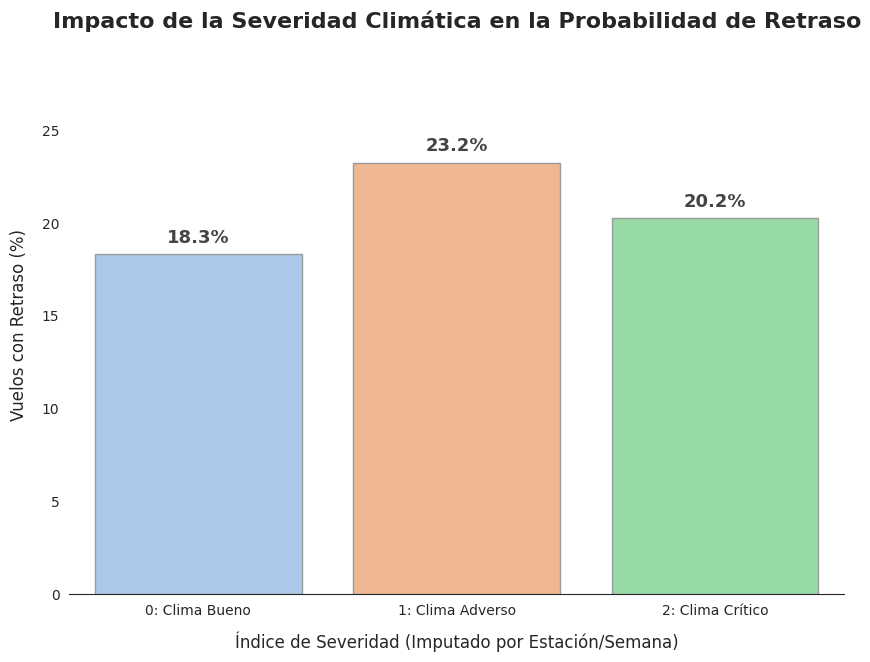


         RESUMEN ESTADÍSTICO DEL IMPACTO

🔹 NIVEL 0 (BUENO):
   La probabilidad de retraso es del 18.29%
------------------------------
🔹 NIVEL 1 (ADVERSO):
   La probabilidad de retraso es del 23.23%
------------------------------
🔹 NIVEL 2 (CRÍTICO):
   La probabilidad de retraso es del 20.24%
------------------------------


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cálculo de probabilidades (en porcentaje)
stats_clima = df_flights_final.groupby('CLIMATE_SEVERITY_IDX')['DEP_DEL15'].mean() * 100

plt.figure(figsize=(10, 7))
sns.set_style("white")

colores_pastel = sns.color_palette("pastel")[0:3]

ax = sns.barplot(x=stats_clima.index, y=stats_clima.values, palette=colores_pastel, edgecolor=".6")


plt.title('Impacto de la Severidad Climática en la Probabilidad de Retraso', fontsize=16, pad=20, fontweight='bold')
plt.ylabel('Vuelos con Retraso (%)', fontsize=12, labelpad=10)
plt.xlabel('Índice de Severidad (Imputado por Estación/Semana)', fontsize=12, labelpad=10)
plt.xticks([0, 1, 2], ['0: Clima Bueno', '1: Clima Adverso', '2: Clima Crítico'])

sns.despine(left=True, bottom=False)

# Añadir etiquetas de valor con formato bold sobre las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 12),
                textcoords = 'offset points',
                fontsize=13, fontweight='bold', color='#444444')

plt.ylim(0, max(stats_clima.values) * 1.25)
plt.show()

# --- ESPACIO
print("\n" + "="*50)
print("         RESUMEN ESTADÍSTICO DEL IMPACTO")
print("="*50 + "\n")

# Resumen numérico
for nivel, prob in stats_clima.items():
    nombre = ['BUENO', 'ADVERSO', 'CRÍTICO'][int(nivel)]
    print(f"🔹 NIVEL {nivel} ({nombre}):")
    print(f"   La probabilidad de retraso es del {prob:.2f}%")
    print("-" * 30)